In [ ]:
from urllib.request import urlretrieve
import zipfile, os
import time
import numpy as np
import pandas as pd
import scipy.sparse as sps
import tqdm.notebook as tq
import matplotlib.pyplot as plt
from bisect import bisect_left
import sys

In [ ]:
#mount drive and indexing
from google.colab import drive
drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive/RecSys/Notebooks')

Mounted at /content/drive


In [ ]:
#creation of episode dataframe from csv
episode_dataframe = pd.read_csv(filepath_or_buffer="/content/drive/MyDrive/RecSys/Challenge_2021/de_compressed/data_ICM_event.csv", 
                                sep=",", 
                                skiprows = 1,
                                header=None, 
                                dtype={0:int, 1:int, 2:float},
                                engine='python')

episode_dataframe.columns = ['Item_id', 'Episode_id', 'Interaction']

In [ ]:
episode_dataframe.head(n=20)

,Item_id,Episode_id,Interaction
0,0,121781,1.0
1,1,150102,1.0
2,1,349614,1.0
3,2,9174,1.0
4,2,20833,1.0
5,2,251794,1.0
6,3,81458,1.0
7,4,84041,1.0
8,5,7823,1.0
9,5,50941,1.0


In [ ]:
#create array to store the number of episodes of each item
item_episodes = np.zeros(episode_dataframe["Item_id"].max() + 1, dtype=int)

In [ ]:
#populate item_episode based on the occourences
for index, row in episode_dataframe.iterrows():
  item_episodes[int(row["Item_id"])] +=1

In [ ]:
#select the relevant percentile that will be the attribute of the new dataset and convert to int
relevant_percentiles = (0.5,20,50,75,90,95)
perc_ranges = [int(x) for x in np.percentile(item_episodes, relevant_percentiles)]
perc_ranges

[0, 1, 3, 8, 29, 77]

In [ ]:
#create matrix to store implicit data based on percentiles
percentile_matrix = np.zeros((episode_dataframe["Item_id"].max() + 1, len(relevant_percentiles)+1), dtype=float)

In [ ]:
#populate matrix with one hot encoding based on the percentile belonging
for index, elem in np.ndenumerate(item_episodes):
  percentile_matrix[index, bisect_left(perc_ranges, elem)] = 1.0

percentile_matrix

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [ ]:
#create dataframe from the matrix with columns represented by the percentiles
item_episodes_df = pd.DataFrame(data=percentile_matrix, columns=[str(i)+"° Percentile" for i in range(len(perc_ranges)+1)])

In [ ]:
item_episodes_df

,0° Percentile,1° Percentile,2° Percentile,3° Percentile,4° Percentile,5° Percentile,6° Percentile
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
18054,0.0,1.0,0.0,0.0,0.0,0.0,0.0
18055,0.0,1.0,0.0,0.0,0.0,0.0,0.0
18056,0.0,0.0,1.0,0.0,0.0,0.0,0.0
18057,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#creation of genre dataframe from csv
genre_dataframe = pd.read_csv(filepath_or_buffer="/content/drive/MyDrive/RecSys/Challenge_2021/de_compressed/data_ICM_genre.csv", 
                                sep=",", 
                                skiprows = 1,
                                header=None, 
                                dtype={0:int, 1:int, 2:float},
                                engine='python')

genre_dataframe.columns = ['Item_id', 'Genre_id', 'Interaction']

In [ ]:
genre_dataframe.head(n=10)

,Item_id,Genre_id,Interaction
0,0,3,1.0
1,1,3,1.0
2,2,6,1.0
3,3,0,1.0
4,3,1,1.0
5,4,4,1.0
6,5,3,1.0
7,6,7,1.0
8,7,6,1.0
9,8,4,1.0


In [ ]:
#count unique genres in dataframe
genre_num = genre_dataframe["Genre_id"].nunique()
genre_num

8

In [ ]:
#convert genre dataframe into sparse matrix in COO format, then re-converting it in dataframe to show classes
genre_matrix = sps.coo_matrix((genre_dataframe["Interaction"].values, 
                          (genre_dataframe["Item_id"].values, genre_dataframe["Genre_id"].values)))

item_genre_df = pd.DataFrame(data=genre_matrix.todense(), columns=[str(i)+"° Genre" for i in range(genre_num)])

In [ ]:
item_genre_df

,0° Genre,1° Genre,2° Genre,3° Genre,4° Genre,5° Genre,6° Genre,7° Genre
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
18054,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
18055,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
18056,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
18057,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
#creation of subgenre dataframe from csv
subgenre_dataframe = pd.read_csv(filepath_or_buffer="/content/drive/MyDrive/RecSys/Challenge_2021/de_compressed/data_ICM_subgenre.csv", 
                                sep=",", 
                                skiprows = 1,
                                header=None, 
                                dtype={0:int, 1:int, 2:float},
                                engine='python')

subgenre_dataframe.columns = ['Item_id', 'Subgenre_id', 'Interaction']

In [ ]:
subgenre_dataframe.head(n=10)

,Item_id,Subgenre_id,Interaction
0,0,70,1.0
1,1,27,1.0
2,2,40,1.0
3,3,50,1.0
4,4,62,1.0
5,5,3,1.0
6,6,99,1.0
7,7,102,1.0
8,8,62,1.0
9,9,61,1.0


In [ ]:
#count unique subgenres in dataframe
subgenre_num = subgenre_dataframe["Subgenre_id"].nunique()
subgenre_num

113

In [ ]:
#convert subgenre dataframe into sparse matrix in COO format, then re-converting it in dataframe to show classes
subgenre_matrix = sps.coo_matrix((subgenre_dataframe["Interaction"].values, 
                          (subgenre_dataframe["Item_id"].values, subgenre_dataframe["Subgenre_id"].values)))

item_subgenre_df = pd.DataFrame(data=subgenre_matrix.todense(), columns=[str(i)+"° Subgenre" for i in range(subgenre_num)])

In [ ]:
item_subgenre_df

,0° Subgenre,1° Subgenre,2° Subgenre,3° Subgenre,4° Subgenre,5° Subgenre,6° Subgenre,7° Subgenre,8° Subgenre,9° Subgenre,10° Subgenre,11° Subgenre,12° Subgenre,13° Subgenre,14° Subgenre,15° Subgenre,16° Subgenre,17° Subgenre,18° Subgenre,19° Subgenre,20° Subgenre,21° Subgenre,22° Subgenre,23° Subgenre,24° Subgenre,25° Subgenre,26° Subgenre,27° Subgenre,28° Subgenre,29° Subgenre,30° Subgenre,31° Subgenre,32° Subgenre,33° Subgenre,34° Subgenre,35° Subgenre,36° Subgenre,37° Subgenre,38° Subgenre,39° Subgenre,...,73° Subgenre,74° Subgenre,75° Subgenre,76° Subgenre,77° Subgenre,78° Subgenre,79° Subgenre,80° Subgenre,81° Subgenre,82° Subgenre,83° Subgenre,84° Subgenre,85° Subgenre,86° Subgenre,87° Subgenre,88° Subgenre,89° Subgenre,90° Subgenre,91° Subgenre,92° Subgenre,93° Subgenre,94° Subgenre,95° Subgenre,96° Subgenre,97° Subgenre,98° Subgenre,99° Subgenre,100° Subgenre,101° Subgenre,102° Subgenre,103° Subgenre,104° Subgenre,105° Subgenre,106° Subgenre,107° Subgenre,108° Subgenre,109° Subgenre,110° Subgenre,111° Subgenre,112° Subgenre
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1805

In [ ]:
#creation of channel dataframe from csv
channel_dataframe = pd.read_csv(filepath_or_buffer="/content/drive/MyDrive/RecSys/Challenge_2021/de_compressed/data_ICM_channel.csv", 
                                sep=",", 
                                skiprows = 1,
                                header=None, 
                                dtype={0:int, 1:int, 2:float},
                                engine='python')

channel_dataframe.columns = ['Item_id', 'Channel_id', 'Interaction']

In [ ]:
channel_dataframe.head(n=10)

,Item_id,Channel_id,Interaction
0,0,23,1.0
1,1,30,1.0
2,2,38,1.0
3,2,53,1.0
4,3,51,1.0
5,4,99,1.0
6,5,152,1.0
7,6,115,1.0
8,7,173,1.0
9,8,36,1.0


In [ ]:
#count unique channels in dataframe
channel_num = channel_dataframe["Channel_id"].nunique()
channel_num

213

In [ ]:
#convert channel dataframe into sparse matrix in COO format, then re-converting it in dataframe to show classes
channel_matrix = sps.coo_matrix((channel_dataframe["Interaction"].values, 
                          (channel_dataframe["Item_id"].values, channel_dataframe["Channel_id"].values)))

item_channel_df = pd.DataFrame(data=channel_matrix.todense(), columns=[str(i)+"° Channel" for i in range(channel_num)])

In [ ]:
item_channel_df

,0° Channel,1° Channel,2° Channel,3° Channel,4° Channel,5° Channel,6° Channel,7° Channel,8° Channel,9° Channel,10° Channel,11° Channel,12° Channel,13° Channel,14° Channel,15° Channel,16° Channel,17° Channel,18° Channel,19° Channel,20° Channel,21° Channel,22° Channel,23° Channel,24° Channel,25° Channel,26° Channel,27° Channel,28° Channel,29° Channel,30° Channel,31° Channel,32° Channel,33° Channel,34° Channel,35° Channel,36° Channel,37° Channel,38° Channel,39° Channel,...,173° Channel,174° Channel,175° Channel,176° Channel,177° Channel,178° Channel,179° Channel,180° Channel,181° Channel,182° Channel,183° Channel,184° Channel,185° Channel,186° Channel,187° Channel,188° Channel,189° Channel,190° Channel,191° Channel,192° Channel,193° Channel,194° Channel,195° Channel,196° Channel,197° Channel,198° Channel,199° Channel,200° Channel,201° Channel,202° Channel,203° Channel,204° Channel,205° Channel,206° Channel,207° Channel,208° Channel,209° Channel,210° Channel,211° Channel,212° Channel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
#create ICM by merging dataframes with same index (item_id)
ICM_df = pd.concat([item_genre_df, item_subgenre_df, item_channel_df, item_episodes_df], axis=1)

In [ ]:
ICM_df

,0° Genre,1° Genre,2° Genre,3° Genre,4° Genre,5° Genre,6° Genre,7° Genre,0° Subgenre,1° Subgenre,2° Subgenre,3° Subgenre,4° Subgenre,5° Subgenre,6° Subgenre,7° Subgenre,8° Subgenre,9° Subgenre,10° Subgenre,11° Subgenre,12° Subgenre,13° Subgenre,14° Subgenre,15° Subgenre,16° Subgenre,17° Subgenre,18° Subgenre,19° Subgenre,20° Subgenre,21° Subgenre,22° Subgenre,23° Subgenre,24° Subgenre,25° Subgenre,26° Subgenre,27° Subgenre,28° Subgenre,29° Subgenre,30° Subgenre,31° Subgenre,...,180° Channel,181° Channel,182° Channel,183° Channel,184° Channel,185° Channel,186° Channel,187° Channel,188° Channel,189° Channel,190° Channel,191° Channel,192° Channel,193° Channel,194° Channel,195° Channel,196° Channel,197° Channel,198° Channel,199° Channel,200° Channel,201° Channel,202° Channel,203° Channel,204° Channel,205° Channel,206° Channel,207° Channel,208° Channel,209° Channel,210° Channel,211° Channel,212° Channel,0° Percentile,1° Percentile,2° Percentile,3° Percentile,4° Percentile,5° Percentile,6° Percentile
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18054,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
18055,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
18056,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
18057,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
#compute some statistics about ICM
count = 0
for index, elem in ICM_df.iterrows():
  count += ICM_df[index: index+1].values.sum()
sparsity = (1-(count/(ICM_df.shape[0]*ICM_df.shape[1])))*100
print("The Dataset has %i" %count + " non-zero elements over a total of %i" %(ICM_df.shape[0]*ICM_df.shape[1]) + " total elements\nData sparsity: %.2f" %sparsity + "%")

The Dataset has 78627 non-zero elements over a total of 6158119 total elements
Data sparsity: 98.72%


In [ ]:
min_attribute_num = 10
max_attribute_num = 10
item_attribute = np.zeros(len(ICM_df), dtype=float)
for index, elem in ICM_df.iterrows():
  item_attribute[index] = ICM_df[index: index+1].values.sum()
  if item_attribute[index]<min_attribute_num:
    min_attribute_num = item_attribute[index]
  if item_attribute[index]>max_attribute_num:
    max_attribute_num = item_attribute[index]
print(min_attribute_num, max_attribute_num)

1.0 98.0


In [ ]:
attribute_distribution = np.array([(item_attribute == value).sum() for value in range(int(item_attribute.max()+1))])
attribute_distribution

array([    0,     1,    25,  1008, 11631,  4070,   955,   244,    75,
          16,     8,     7,     5,     7,     1,     4,     1,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


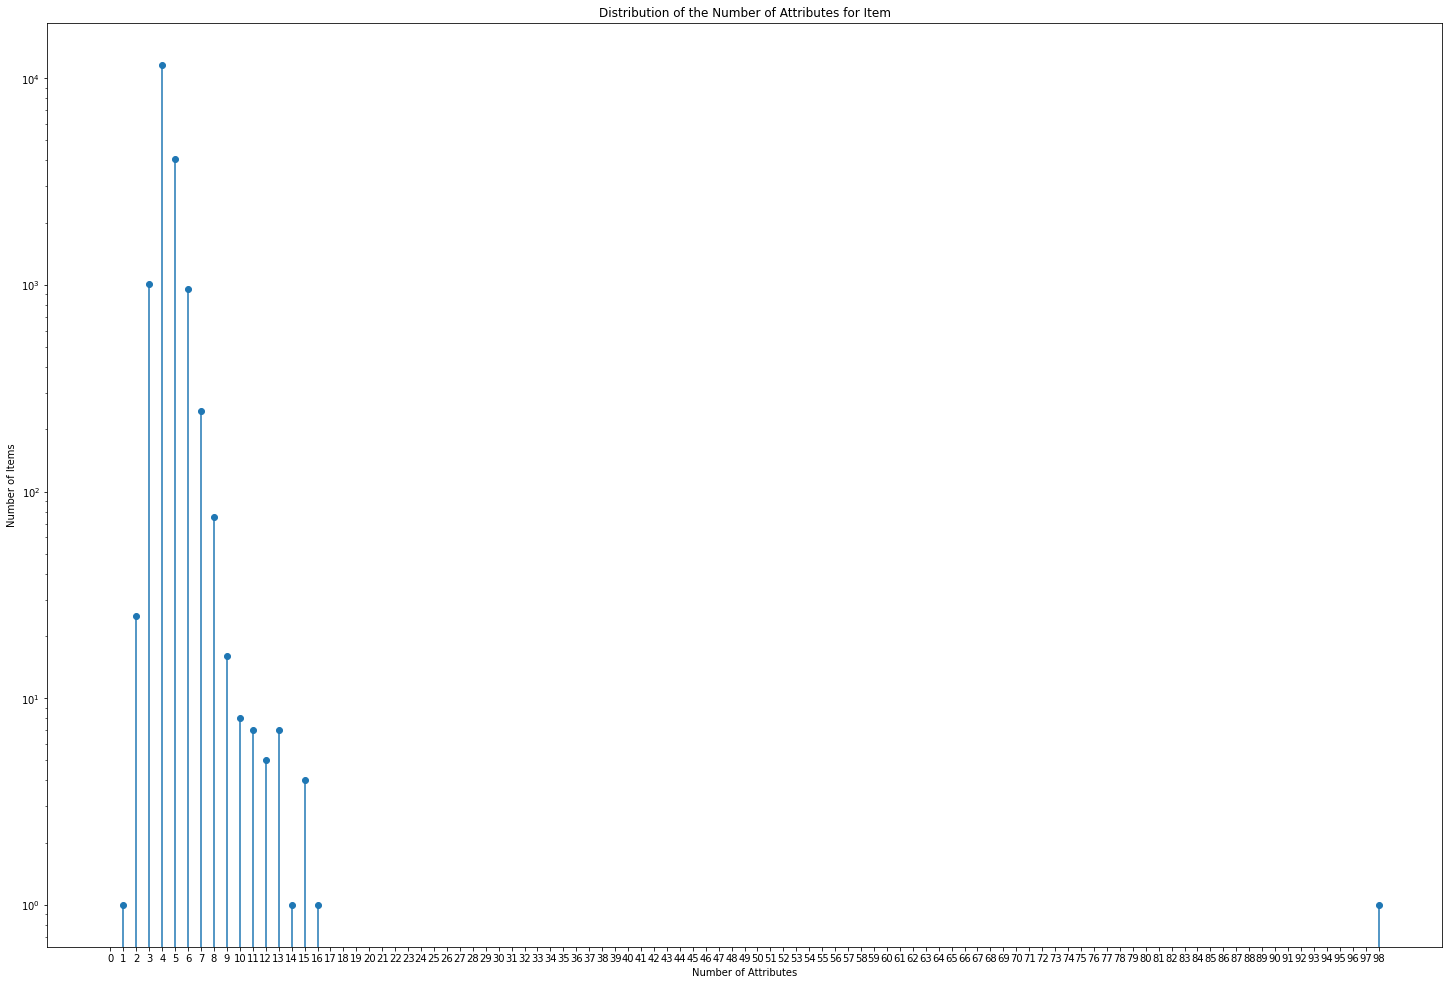

In [ ]:
plt.figure(figsize=(25,17))
plt.stem(attribute_distribution)
plt.xticks(range(len(attribute_distribution)))
plt.yscale('log')
plt.title("Distribution of the Number of Attributes for Item")
plt.xlabel("Number of Attributes")
plt.ylabel("Number of Items")
plt.show()

In [ ]:
URM_all_df = pd.read_csv(filepath_or_buffer="/content/drive/MyDrive/RecSys/Challenge_2021/de_compressed/data_train.csv", 
                                sep=",", 
                                skiprows = 1,
                                header=None, 
                                dtype={0:int, 1:int, 2:float},
                                engine='python')

URM_all_df.columns = ["UserID", "ItemID", "Interaction"]

In [ ]:
URM_all = sps.coo_matrix((URM_all_df["Interaction"].values, 
                          (URM_all_df["UserID"].values, URM_all_df["ItemID"].values)))
URM_all = URM_all.tocsr()

In [ ]:
URM_df = pd.DataFrame(data=URM_all.todense()) 

In [ ]:
min_interaction_num = 100
max_interaction_num = 100
user_item = np.zeros(len(URM_df), dtype=float)
for index, elem in URM_df.iterrows():
  user_item[index] = URM_df[index: index+1].values.sum()
  if user_item[index]<min_interaction_num:
    min_interaction_num = user_item[index]
  if user_item[index]>max_interaction_num:
    max_interaction_num = user_item[index]
print(min_interaction_num, max_interaction_num)

9.0 2191.0


In [ ]:
interaction_distribution = np.array([(user_item == value).sum() for value in range(int(user_item.max()+1))])
interaction_distribution

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
plt.figure(figsize=(500,50))
plt.stem(interaction_distribution)
plt.xticks(range(len(interaction_distribution)))
plt.yticks(range(interaction_distribution.max()))
plt.title("Distribution of the Number of Interactions for User")
plt.xlabel("Number of Interactions")
plt.ylabel("Number of Users")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


In [ ]:
np.percentile(item_attribute, (1,5,10,20,30,40,50,60,70,80,90,95,99))

array([3., 3., 4., 4., 4., 4., 4., 4., 4., 5., 5., 6., 7.])

In [ ]:
np.percentile(user_item, (1,5,10,25,30,40,50,60,75,80,90,95,99))

array([  21.49,   68.  ,  113.  ,  207.  ,  231.  ,  286.  ,  340.  ,
        399.  ,  513.  ,  563.  ,  721.  ,  867.  , 1203.  ])

In [ ]:
user_item.max()

2191.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until


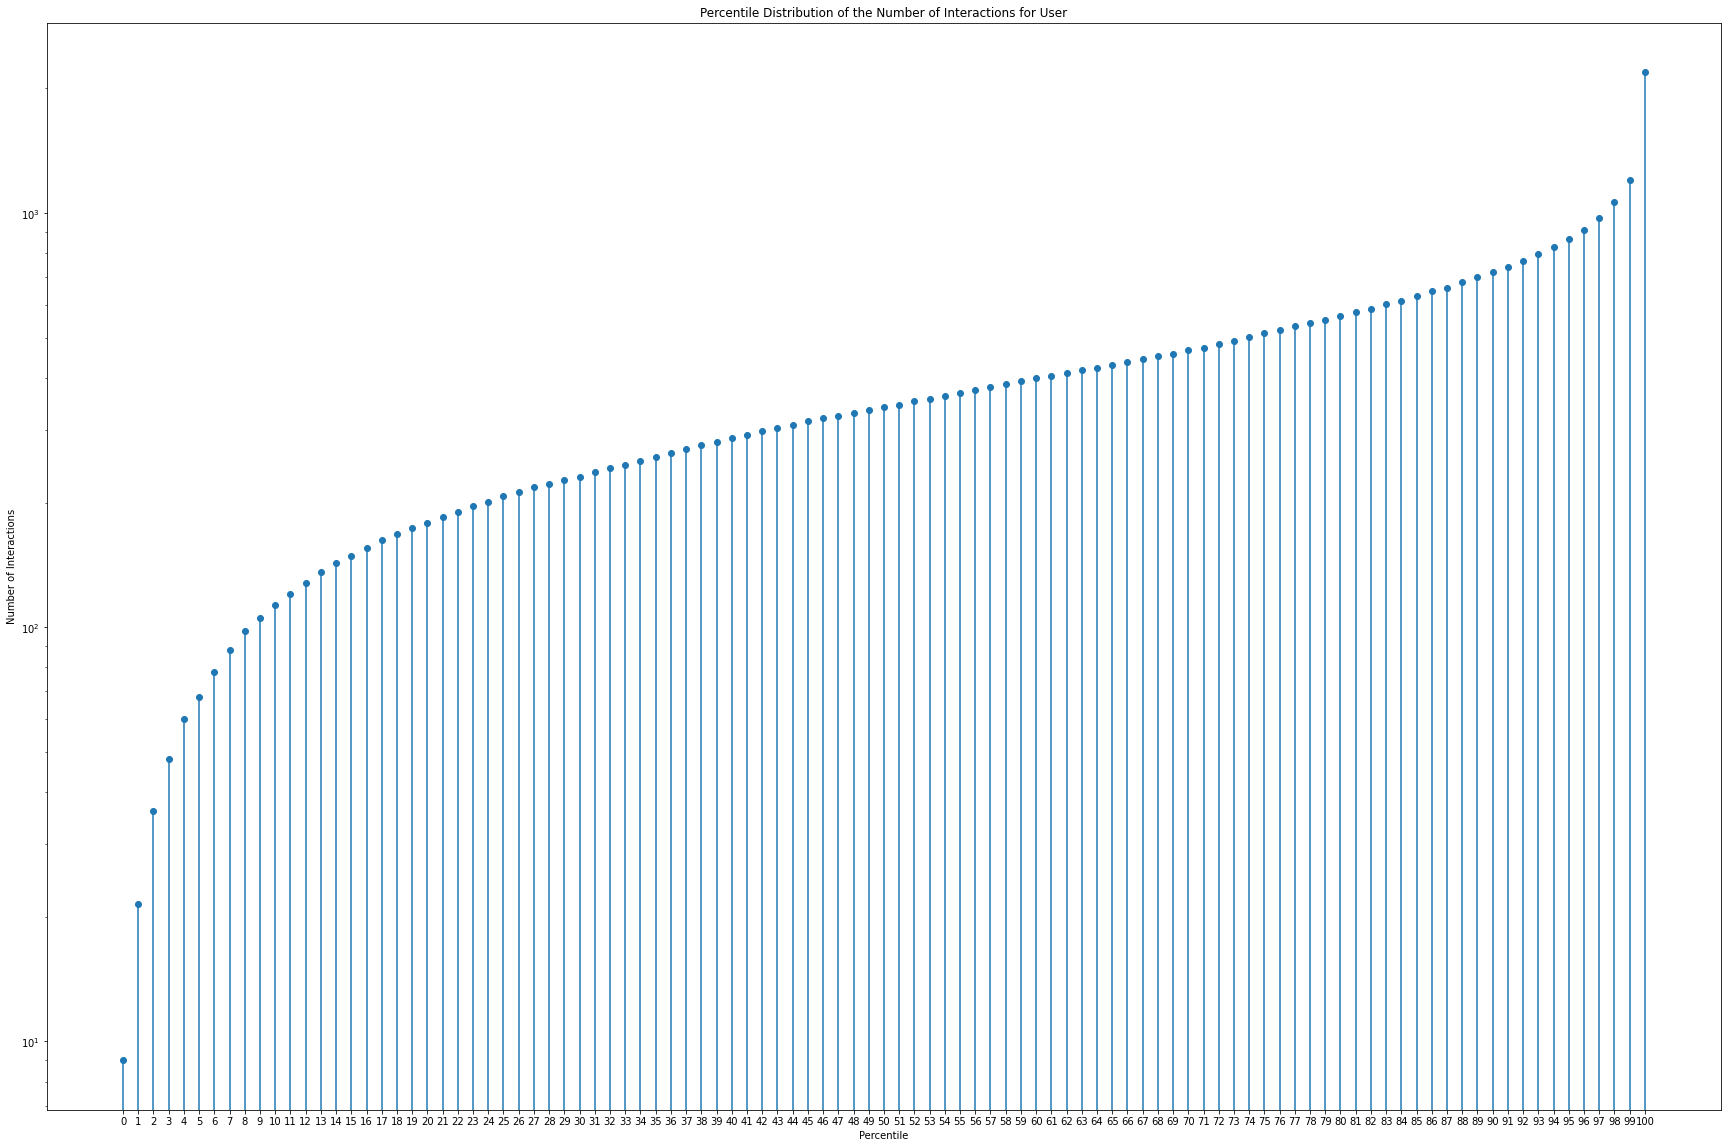

In [ ]:
perc = np.percentile(user_item, [i for i in range(0,101)])
plt.figure(figsize=(30,20))
plt.stem(perc)
plt.xticks(range(len(perc)))
plt.yticks(range(int(user_item.max())))
plt.yscale('log')
plt.title("Percentile Distribution of the Number of Interactions for User")
plt.ylabel("Number of Interactions")
plt.xlabel("Percentile")
plt.show()

In [ ]:
min_num_channel = 10
max_num_channel = 10
item_channel = np.zeros(len(item_channel_df), dtype=float)
for index, elem in item_channel_df.iterrows():
  item_channel[index] = item_channel_df[index: index+1].values.sum()
  if item_channel[index]<min_num_channel:
    min_num_channel = item_channel[index]
  if item_channel[index]>max_num_channel:
    max_num_channel = item_channel[index]
print(min_num_channel, max_num_channel)

0.0 95.0


In [ ]:
item_channel.argmax()
print(item_channel_df.loc[item_channel.argmax()])

0° Channel      0.0
1° Channel      0.0
2° Channel      1.0
3° Channel      0.0
4° Channel      0.0
               ... 
208° Channel    1.0
209° Channel    1.0
210° Channel    1.0
211° Channel    0.0
212° Channel    1.0
Name: 6177, Length: 213, dtype: float64


In [ ]:
channel_distribution = np.array([(item_channel == value).sum() for value in range(int(item_channel.max()+1))])
channel_distribution

array([  352, 12733,  3819,   816,   224,    69,    12,    10,     7,
           4,     6,     2,     3,     1,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     1])

In [ ]:
np.percentile(item_channel, (1,5,25,50,75,90,95,99))

array([0., 1., 1., 1., 2., 2., 3., 4.])

In [ ]:
no_channel_item = []
for index, elem in item_channel_df.iterrows():
  if elem.sum() == 0:
    no_channel_item.append(index)

print(no_channel_item)

[19, 88, 238, 250, 321, 399, 421, 441, 444, 488, 515, 529, 579, 612, 643, 649, 701, 758, 797, 1014, 1142, 1185, 1197, 1227, 1422, 1534, 1567, 1640, 1749, 1811, 1885, 1995, 2070, 2084, 2087, 2172, 2264, 2284, 2286, 2299, 2384, 2404, 2457, 2464, 2567, 2589, 2625, 2676, 2694, 2773, 2778, 2798, 2856, 2975, 2983, 3033, 3072, 3073, 3109, 3246, 3333, 3441, 3453, 3463, 3492, 3528, 3618, 3651, 3773, 3788, 3814, 3866, 3874, 3881, 3890, 3974, 4003, 4023, 4043, 4153, 4291, 4351, 4401, 4542, 4546, 4617, 4696, 4749, 4815, 4867, 4877, 4921, 4996, 5032, 5084, 5100, 5139, 5147, 5191, 5194, 5376, 5413, 5421, 5505, 5540, 5559, 5586, 5691, 5702, 5820, 5829, 5835, 5879, 5978, 6034, 6097, 6121, 6173, 6296, 6378, 6510, 6581, 6604, 6625, 6632, 6688, 6765, 6766, 6774, 6795, 6806, 6949, 7007, 7024, 7099, 7128, 7131, 7144, 7175, 7233, 7260, 7266, 7311, 7336, 7344, 7346, 7368, 7388, 7423, 7583, 7658, 7682, 7708, 7873, 7881, 7939, 7941, 7994, 8084, 8144, 8147, 8217, 8344, 8361, 8414, 8433, 8452, 8454, 8514, 8598, 

In [ ]:
URM_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,18019,18020,18021,18022,18023,18024,18025,18026,18027,18028,18029,18030,18031,18032,18033,18034,18035,18036,18037,18038,18039,18040,18041,18042,18043,18044,18045,18046,18047,18048,18049,18050,18051,18052,18053,18054,18055,18056,18057,18058
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13645,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
13646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
watch_rate = {}
max_value = 0
max_index = -1
for index in no_channel_item:
  watch_rate[index] = URM_df.loc[:,index].sum()
  if URM_df.loc[:,index].sum() > max_value:
    max_value = URM_df.loc[:,index].sum()
    max_index = index

print(watch_rate, str(max_index) + ":" + str(max_value))

{19: 427.0, 88: 238.0, 238: 25.0, 250: 30.0, 321: 19.0, 399: 423.0, 421: 440.0, 441: 163.0, 444: 56.0, 488: 46.0, 515: 405.0, 529: 12.0, 579: 263.0, 612: 85.0, 643: 451.0, 649: 347.0, 701: 9.0, 758: 39.0, 797: 124.0, 1014: 482.0, 1142: 33.0, 1185: 1408.0, 1197: 61.0, 1227: 123.0, 1422: 244.0, 1534: 11.0, 1567: 29.0, 1640: 17.0, 1749: 60.0, 1811: 303.0, 1885: 4433.0, 1995: 34.0, 2070: 32.0, 2084: 2330.0, 2087: 2212.0, 2172: 22.0, 2264: 21.0, 2284: 406.0, 2286: 5.0, 2299: 488.0, 2384: 104.0, 2404: 37.0, 2457: 42.0, 2464: 35.0, 2567: 10.0, 2589: 37.0, 2625: 249.0, 2676: 182.0, 2694: 31.0, 2773: 88.0, 2778: 259.0, 2798: 34.0, 2856: 14.0, 2975: 9.0, 2983: 56.0, 3033: 75.0, 3072: 595.0, 3073: 193.0, 3109: 11.0, 3246: 249.0, 3333: 774.0, 3441: 39.0, 3453: 55.0, 3463: 72.0, 3492: 951.0, 3528: 186.0, 3618: 114.0, 3651: 36.0, 3773: 12.0, 3788: 32.0, 3814: 23.0, 3866: 15.0, 3874: 266.0, 3881: 133.0, 3890: 6.0, 3974: 47.0, 4003: 14.0, 4023: 251.0, 4043: 61.0, 4153: 7.0, 4291: 523.0, 4351: 9.0, 440

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


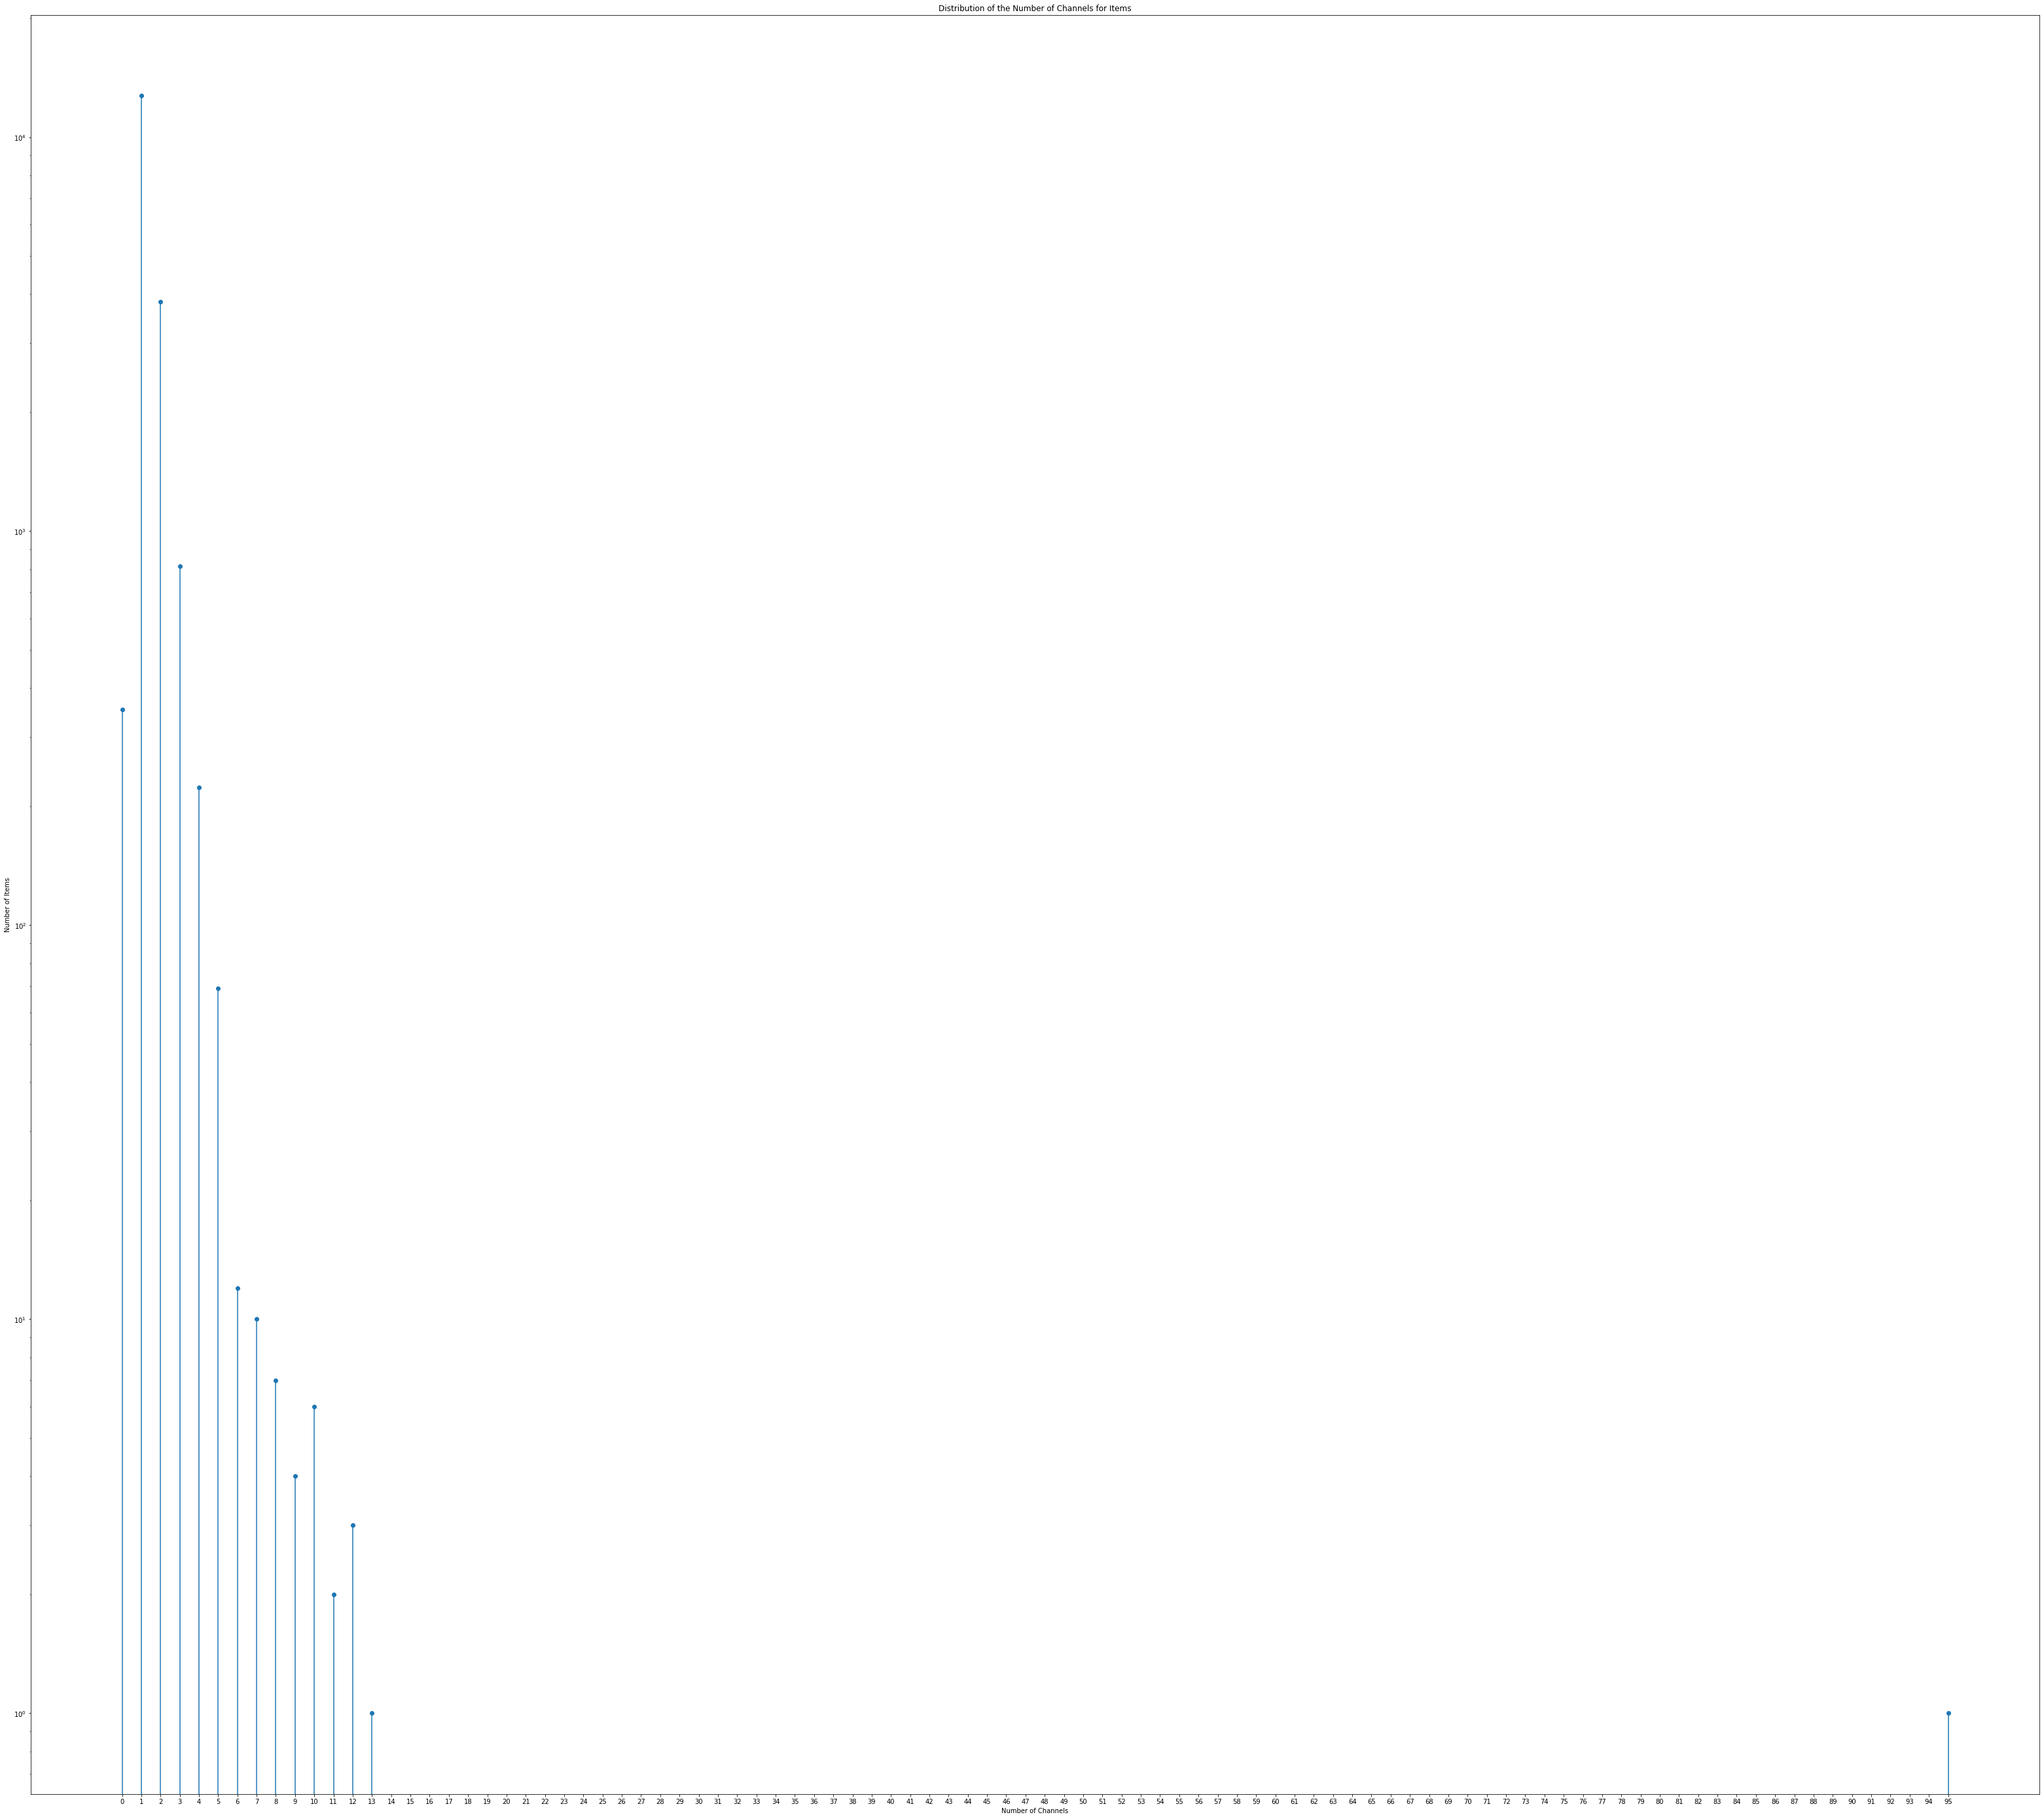

In [ ]:
plt.figure(figsize=(55,50))
plt.stem(channel_distribution)
plt.xticks(range(len(channel_distribution)))
plt.yticks(range(channel_distribution.max()))
plt.yscale('log')
plt.title("Distribution of the Number of Channels for Items")
plt.xlabel("Number of Channels")
plt.ylabel("Number of Items")
plt.show()

In [ ]:
episode_matrix = sps.coo_matrix((episode_dataframe["Interaction"].values, 
                          (episode_dataframe["Item_id"].values, episode_dataframe["Episode_id"].values)))

#crasha brutalmente
#episode_extended_dataframe = pd.DataFrame(data=episode_matrix.todense(), columns=["Episode n°" + str(i) for i in range(episode_dataframe["Episode_id"].nunique())])
#episode_extended_dataframe.head(n=10)

In [ ]:
no_episode_item = []
for i in range(episode_matrix.shape[0]):
  if episode_matrix.getrow(i).sum() == 0:
    no_episode_item.append(i)

print(no_episode_item)

[23, 472, 1116, 1211, 1319, 1413, 1719, 1906, 1916, 2158, 2418, 2572, 2573, 2685, 2755, 3236, 3460, 3560, 3659, 4033, 4402, 5495, 5550, 5708, 5816, 5886, 6058, 6100, 6131, 6159, 6985, 6999, 7028, 7232, 7388, 7395, 7401, 7455, 7567, 7755, 7869, 7945, 8201, 8296, 8778, 9254, 9321, 9351, 9373, 10152, 10895, 10907, 10987, 11044, 11071, 11106, 11236, 11628, 12087, 12757, 12783, 13159, 13339, 13413, 13515, 13533, 13733, 13767, 13855, 13863, 14056, 14132, 14270, 14804, 14872, 15120, 15185, 15192, 15425, 15489, 15576, 15863, 15919, 16796, 16852, 17097, 17167, 17361, 17602, 17646, 17819, 17977]


In [ ]:
watch_rate = {}
max_value = 0
max_index = -1
for index in no_episode_item:
  watch_rate[index] = URM_df.loc[:,index].sum()
  if URM_df.loc[:,index].sum() > max_value:
    max_value = URM_df.loc[:,index].sum()
    max_index = index

print(watch_rate, str(max_index) + ":" + str(max_value))

{23: 83.0, 472: 72.0, 1116: 59.0, 1211: 89.0, 1319: 12.0, 1413: 395.0, 1719: 482.0, 1906: 86.0, 1916: 31.0, 2158: 171.0, 2418: 16.0, 2572: 102.0, 2573: 24.0, 2685: 79.0, 2755: 265.0, 3236: 61.0, 3460: 1995.0, 3560: 21.0, 3659: 26.0, 4033: 9.0, 4402: 34.0, 5495: 782.0, 5550: 470.0, 5708: 14.0, 5816: 382.0, 5886: 31.0, 6058: 731.0, 6100: 36.0, 6131: 22.0, 6159: 50.0, 6985: 20.0, 6999: 89.0, 7028: 29.0, 7232: 56.0, 7388: 9.0, 7395: 18.0, 7401: 177.0, 7455: 12.0, 7567: 11.0, 7755: 26.0, 7869: 1266.0, 7945: 13.0, 8201: 27.0, 8296: 31.0, 8778: 10.0, 9254: 7.0, 9321: 5.0, 9351: 10.0, 9373: 2470.0, 10152: 816.0, 10895: 9.0, 10907: 297.0, 10987: 19.0, 11044: 1057.0, 11071: 53.0, 11106: 515.0, 11236: 326.0, 11628: 15.0, 12087: 554.0, 12757: 18.0, 12783: 13.0, 13159: 109.0, 13339: 180.0, 13413: 74.0, 13515: 30.0, 13533: 17.0, 13733: 46.0, 13767: 60.0, 13855: 13.0, 13863: 209.0, 14056: 8.0, 14132: 15.0, 14270: 58.0, 14804: 82.0, 14872: 38.0, 15120: 10.0, 15185: 334.0, 15192: 43.0, 15425: 161.0, 15

In [ ]:
for elem in no_episode_item:
  assert episode_dataframe["Item_id"].all() != elem

In [ ]:
inter = list(set(no_episode_item).intersection(no_channel_item))
magic_watchers = [URM_df.loc[:,index].sum() for index in inter]
print(inter, magic_watchers)

[7388, 9254] [9.0, 7.0]


In [ ]:
Magic_ICM = ICM_df.copy()

In [ ]:
configurations = set()
for index, elem in Magic_ICM.iterrows():
  configurations.add(str([int(i) for i in list(Magic_ICM.iloc[index, 0:121])]).replace(", ", "").replace("[", "").replace("]", ""))

print(len(configurations))

908


In [ ]:
from collections import Counter

In [ ]:
config_counter = Counter([str([int(i) for i in list(Magic_ICM.iloc[index, 0:121])]).replace(", ", "").replace("[", "").replace("]", "") for index, elem in Magic_ICM.iterrows()])
config_counter = dict(config_counter)
config_counter = np.array(list(config_counter.values()))

In [ ]:
ordered_indexes = np.flip(config_counter.argsort())

In [ ]:
np.percentile(config_counter, (0,10,25,50,75,90,99))

array([  1.  ,   1.  ,   1.  ,   1.  ,   2.  ,  14.  , 375.16])

In [ ]:
confs = np.zeros(config_counter.max()+1, dtype=float)
for i in config_counter:
  confs[i] += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


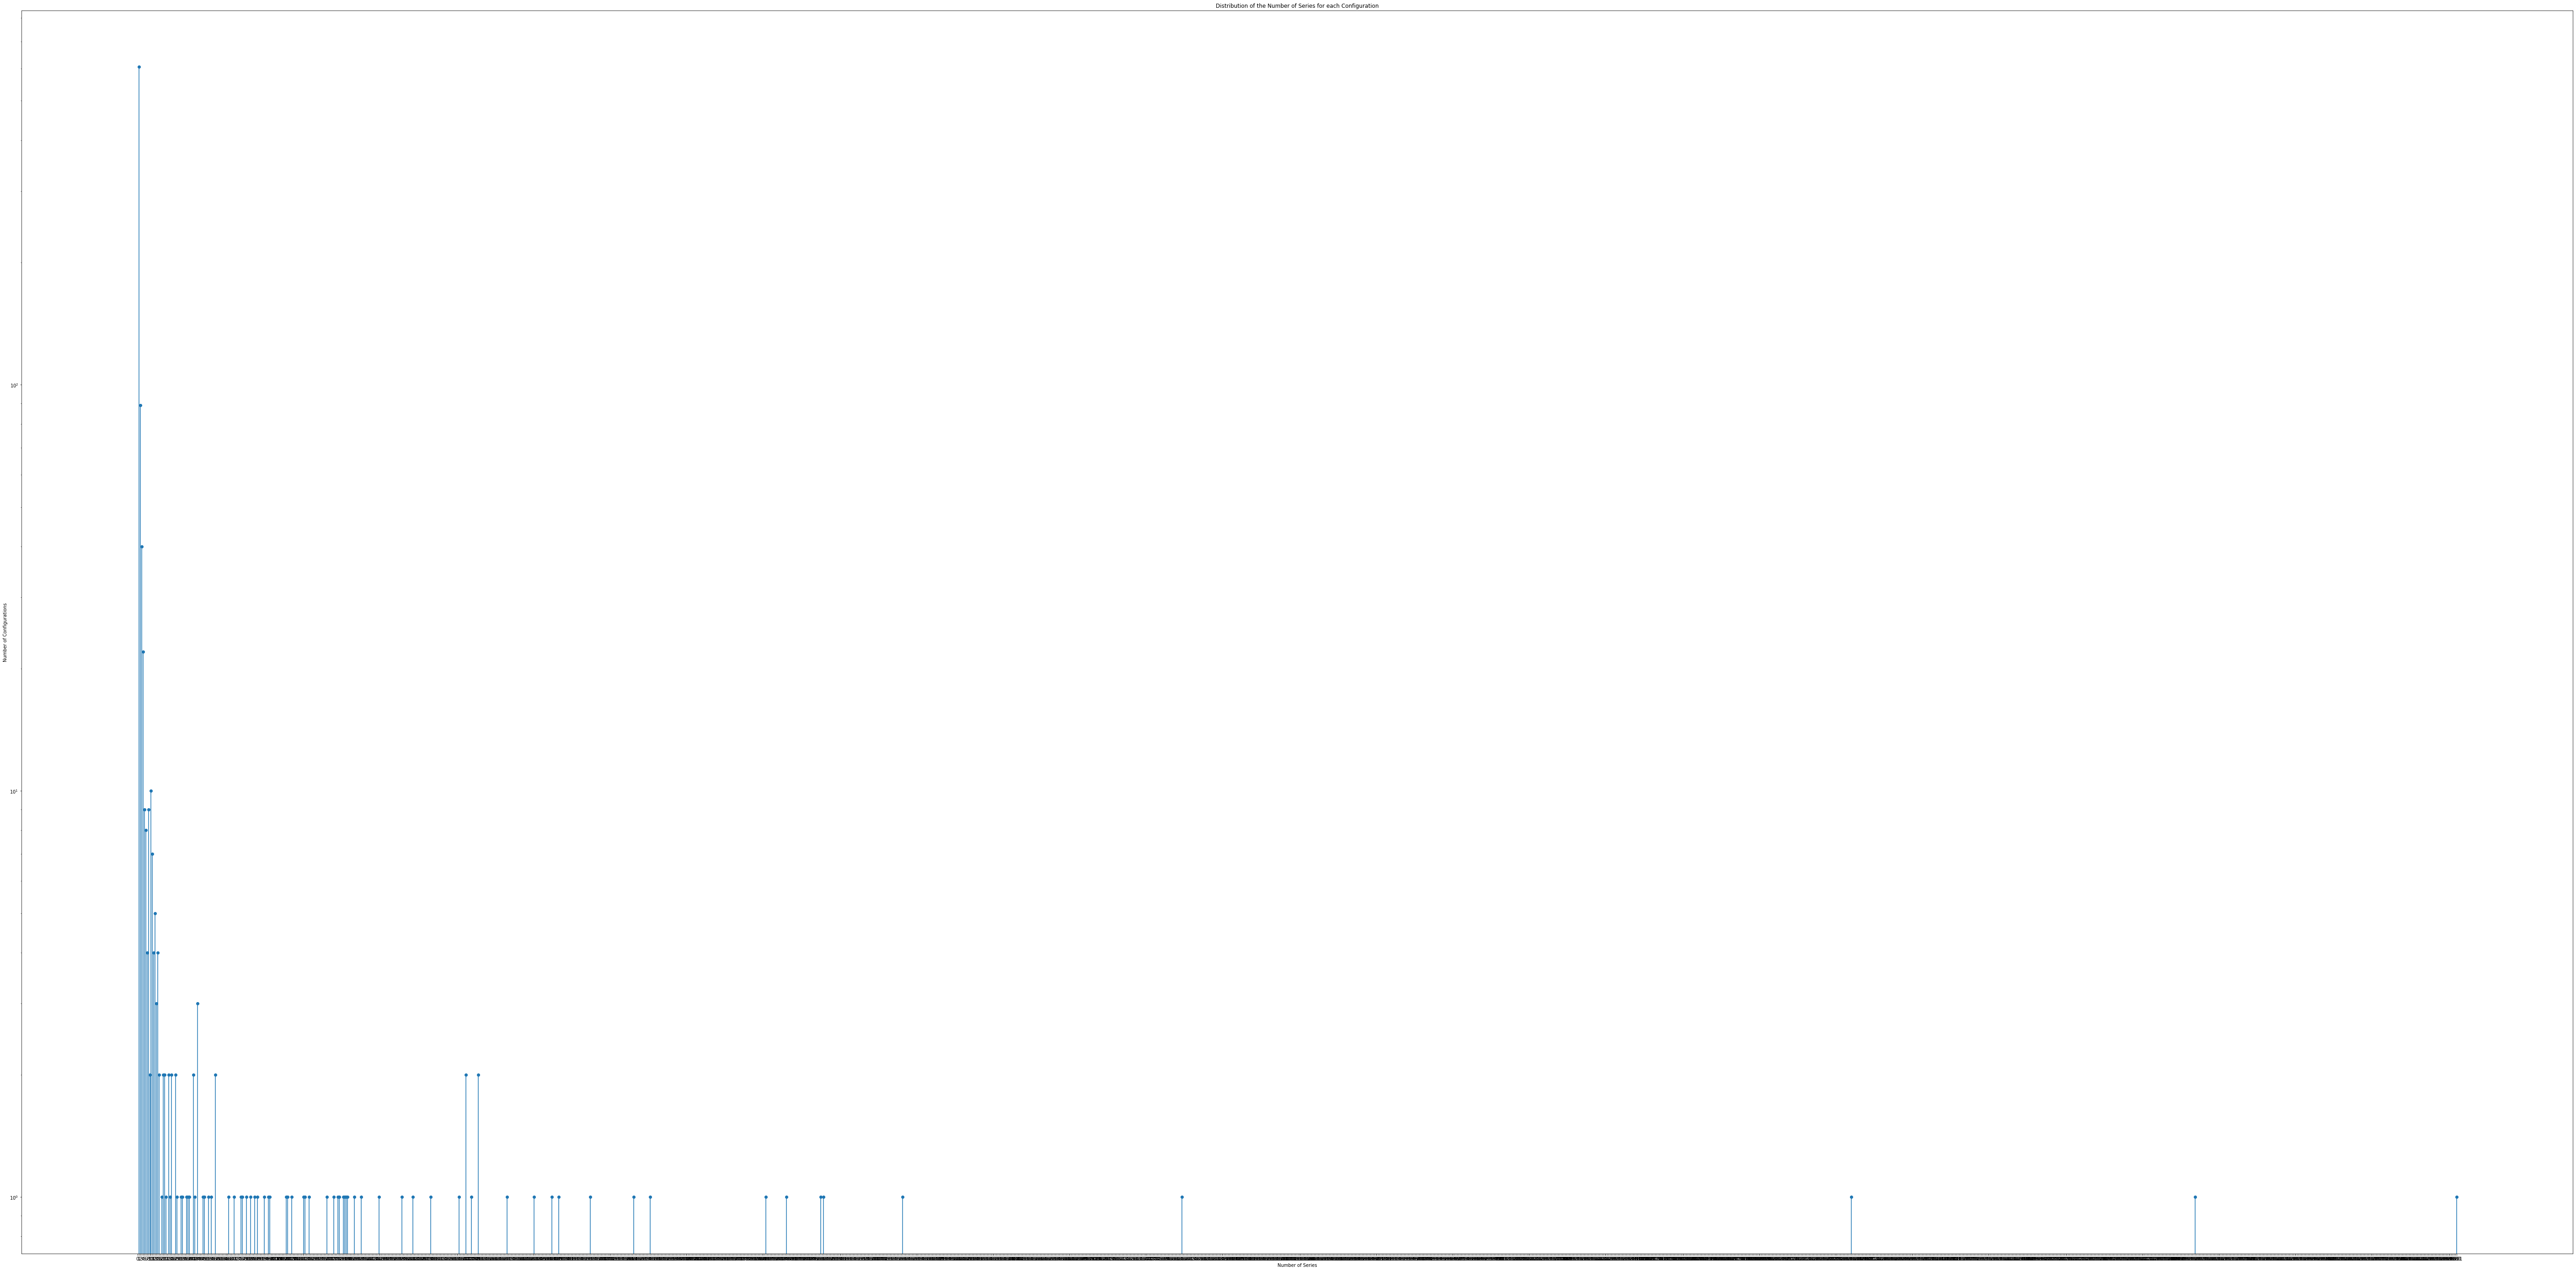

In [ ]:
plt.figure(figsize=(100,50))
plt.stem(confs)
plt.xticks(range(len(confs)))
plt.yticks(range(int(confs.max())))
plt.yscale('log')
plt.title("Distribution of the Number of Series for each Configuration")
plt.xlabel("Number of Series")
plt.ylabel("Number of Configurations")
plt.show()

In [ ]:
c = Counter(episode_dataframe['Episode_id'])

In [ ]:
duplicates = [elem[0] for elem in c.most_common() if elem[1] > 1]

In [ ]:
len(duplicates)

10088

In [ ]:
non_disjointed_series = []
for e in tq.tqdm(duplicates):
  non_disjointed_series.extend(list(episode_dataframe.loc[episode_dataframe['Episode_id'] == e]['Item_id']))
non_disjointed_series = Counter(non_disjointed_series)
non_disjointed_series.most_common(n=20)

  0%|          | 0/10088 [00:00<?, ?it/s]

[(7716, 156),
 (7744, 130),
 (1846, 122),
 (11339, 101),
 (202, 87),
 (14396, 79),
 (5951, 75),
 (7264, 72),
 (6670, 60),
 (17266, 56),
 (11491, 52),
 (6724, 48),
 (11430, 48),
 (13549, 45),
 (10010, 41),
 (17411, 37),
 (14627, 37),
 (7867, 37),
 (7809, 36),
 (1205, 36)]

In [ ]:
len(non_disjointed_series)

9633

In [ ]:
#save dataframe as pickle file
ICM_df.to_pickle("ICM_df.pkl")

In [ ]:
#reload dataframe and check integrity
ICM_df_load = pd.read_pickle("ICM_df.pkl")
ICM_df.equals(ICM_df_load)

True